# Preprocessing
In this notebook 6 final files are created for training, validation and training with oversampling. Each dataset is composed by a values array and a labels array. In this way, all the models can be trained with the same training and validation sets.

The goal is to split randomly and with stratification the given dataset in training and validation set (0.2).

Also, another version of training set is created by oversampling all the windows of each category to reach a given target (800).

## Initialization

### Dataset folder

Change this string with the path for the unzipped files of the given dataset

In [1]:
path_to_dataset = "/content/input/"

### Connect to Drive
This section is used only to copy and unzip the dataset from the shared Drive folder

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
!cp /gdrive/MyDrive/AN2DL/Homework2/training_dataset_homework2.zip /content
!rm -f x_train.npy x_train.npy
!unzip -o training_dataset_homework2.zip
!mkdir -p /content/input
!mv /content/x_train.npy /content/input
!mv /content/y_train.npy /content/input

Archive:  training_dataset_homework2.zip
  inflating: y_train.npy             
  inflating: x_train.npy             


### Import libraries

In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import sklearn.preprocessing as sklp
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Read original dataset

### Load

In [6]:
x_ds_arr_path = os.path.join(path_to_dataset, "x_train.npy")
y_ds_arr_path = os.path.join(path_to_dataset, "y_train.npy")

In [7]:
x_ds_arr = np.load(x_ds_arr_path)
y_ds_arr = np.load(y_ds_arr_path)

In [8]:
x_ds_arr.shape, y_ds_arr.shape

((2429, 36, 6), (2429,))

In [9]:
x_train_orig = x_ds_arr
y_train_orig = tfk.utils.to_categorical(y_ds_arr, num_classes=12)

### Create dataframe

Here we create a dataframe to make simpler the analysis by using the Pandas functions.

In [10]:
ds_dict = {
    "id": [],
    "user_id": [],
    "category": [],
    "x1": [],
    "x2": [],
    "x3": [],
    "x4": [],
    "x5": [],
    "x6": [],
}

for i in range(x_ds_arr.shape[0]):
  for j in range(36):
    user_id = i + 1
    category = y_ds_arr[i]
    id = "{}_{}".format(user_id, category)
    ds_dict["id"].append(id)
    ds_dict["user_id"].append(user_id)
    ds_dict["category"].append(y_ds_arr[i])
    ds_dict["x1"].append(x_ds_arr[i][j][0])
    ds_dict["x2"].append(x_ds_arr[i][j][1])
    ds_dict["x3"].append(x_ds_arr[i][j][2])
    ds_dict["x4"].append(x_ds_arr[i][j][3])
    ds_dict["x5"].append(x_ds_arr[i][j][4])
    ds_dict["x6"].append(x_ds_arr[i][j][5])

ds_df = pd.DataFrame(ds_dict)
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87444 entries, 0 to 87443
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        87444 non-null  object 
 1   user_id   87444 non-null  int64  
 2   category  87444 non-null  int32  
 3   x1        87444 non-null  float64
 4   x2        87444 non-null  float64
 5   x3        87444 non-null  float64
 6   x4        87444 non-null  float64
 7   x5        87444 non-null  float64
 8   x6        87444 non-null  float64
dtypes: float64(6), int32(1), int64(1), object(1)
memory usage: 5.7+ MB


## Analysis

### Distribution

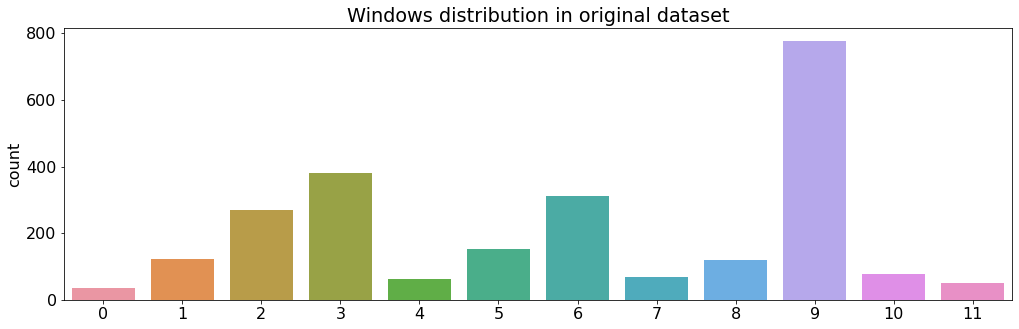

In [11]:
plt.figure(figsize=(17,5))
sns.countplot(x=y_ds_arr)
plt.title('Windows distribution in original dataset')
plt.show()

In the given dataset categories are saved numerically. A map is needed for conversion.

In [12]:
target_categories = {
    0: "Wish",
    1: "Another",
    2: "Comfortably",
    3: "Money",
    4: "Breathe",
    5: "Time",
    6: "Brain",
    7: "Echoes",
    8: "Wearing",
    9: "Sorrow",
    10: "Hey",
    11: "Shine",
}

Convert labels from integer to string

In [13]:
df = ds_df.copy()
df['category'] = df['category'].apply(lambda col: target_categories[col])
df.head()

,id,user_id,category,x1,x2,x3,x4,x5,x6
0,1_0,1,Wish,17.59700,8.1713,-1.78420,-19.70600,-9.7135,-61.887
1,1_0,1,Wish,0.22974,-5.8956,16.83700,5.03900,2.4332,58.914
2,1_0,1,Wish,-29.65400,-21.2960,29.10300,-0.47503,75.3910,10.665
3,1_0,1,Wish,-59.21000,-29.5650,17.97100,-45.60600,19.4120,-43.014
4,1_0,1,Wish,-72.06400,-25.8550,0.46536,-59.15100,-29.1050,-11.913


Number of elements for each category.

In [14]:
df.groupby('category').count()['x1']

category
Another         4428
Brain          11268
Breathe         2232
Comfortably     9720
Echoes          2448
Hey             2772
Money          13716
Shine           1836
Sorrow         27972
Time            5508
Wearing         4320
Wish            1224
Name: x1, dtype: int64

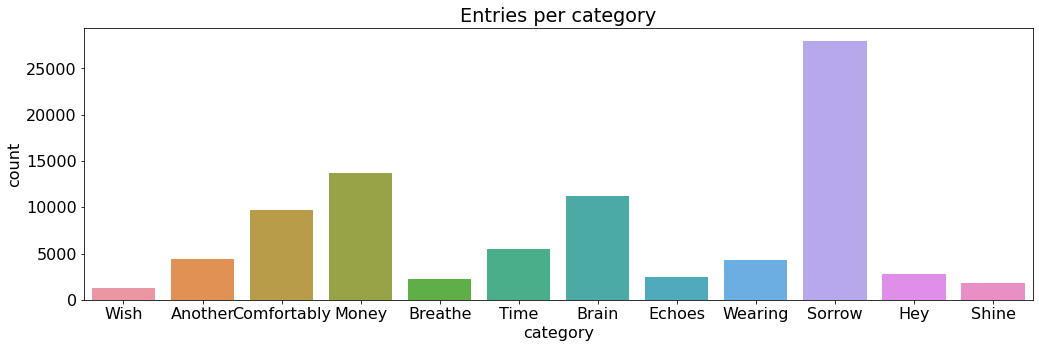

In [15]:
plt.figure(figsize=(17,5))
sns.countplot(data=df, x='category')
plt.title('Entries per category')
plt.show()

### Categories inspection

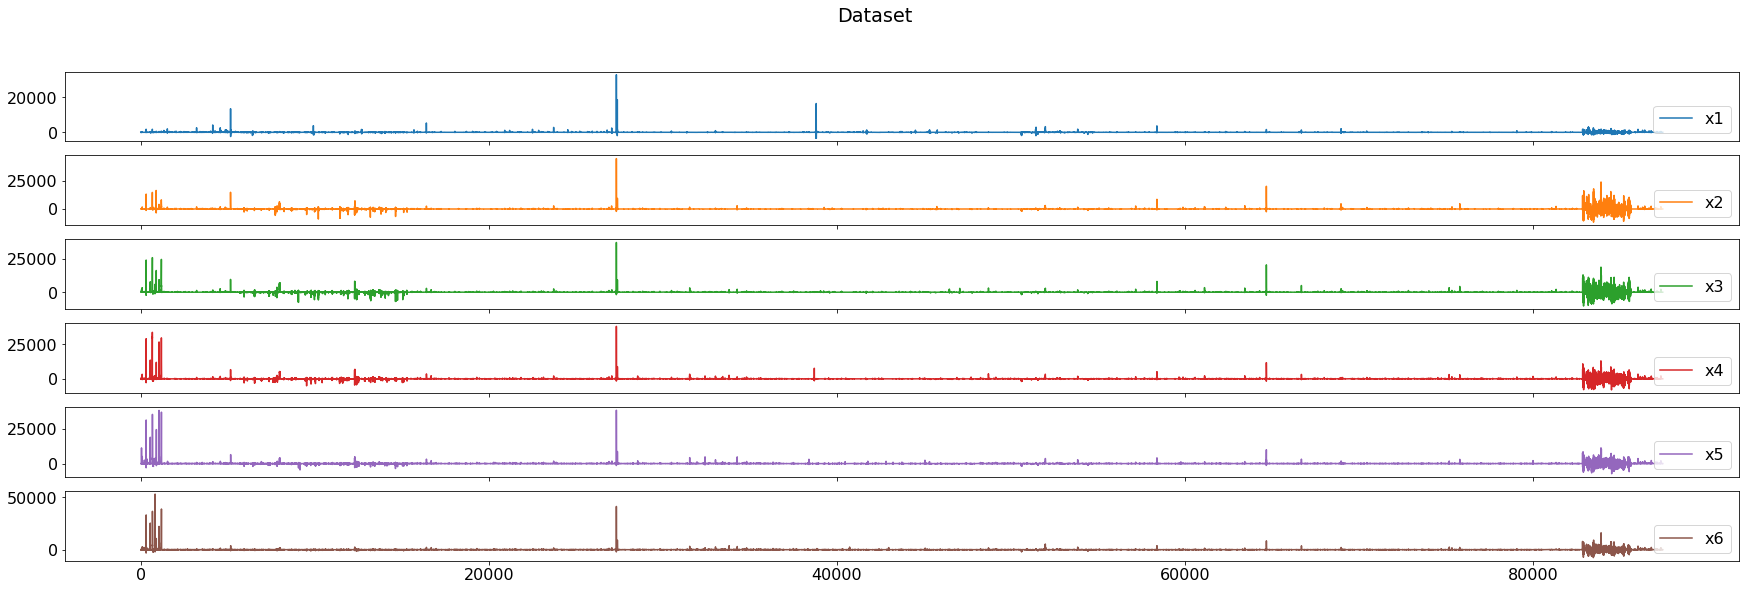

In [16]:
data = df[['x1', 'x2', 'x3', 'x4', 'x5', 'x6']][:]
axis = data.plot(subplots=True, figsize=(30, 9), title="Dataset")
for ax in axis:
    ax.legend(loc='lower right')

In [17]:
def inspect_category(activity, df):
    data = df[df['category'] == activity][['x1', 'x2', 'x3', 'x4', 'x5', 'x6']][:]
    axis = data.plot(subplots=True, figsize=(17, 9), title=activity)
    for ax in axis:
        ax.legend(loc='lower right')

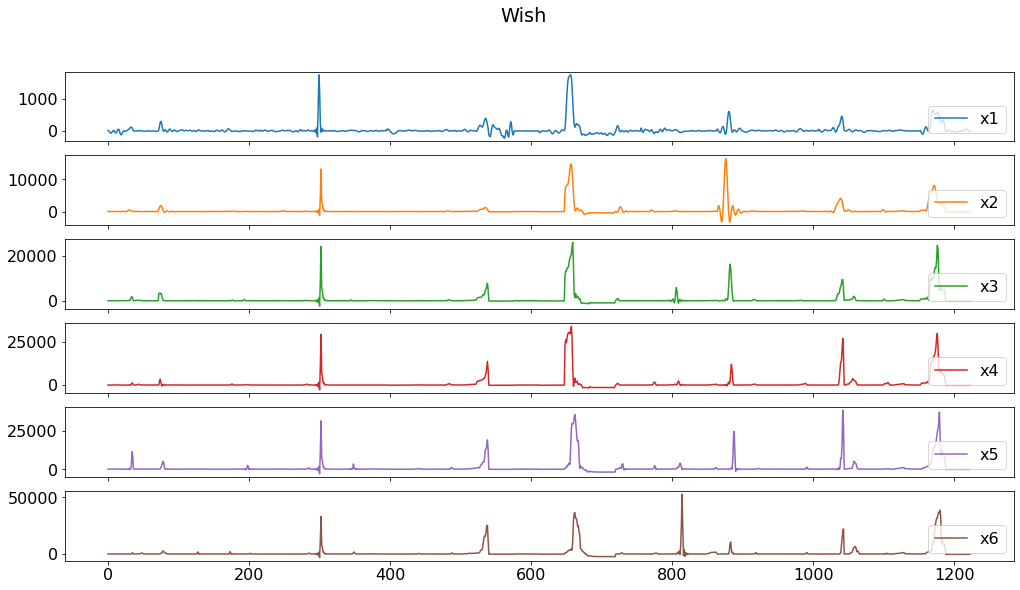

In [18]:
inspect_category("Wish", df)

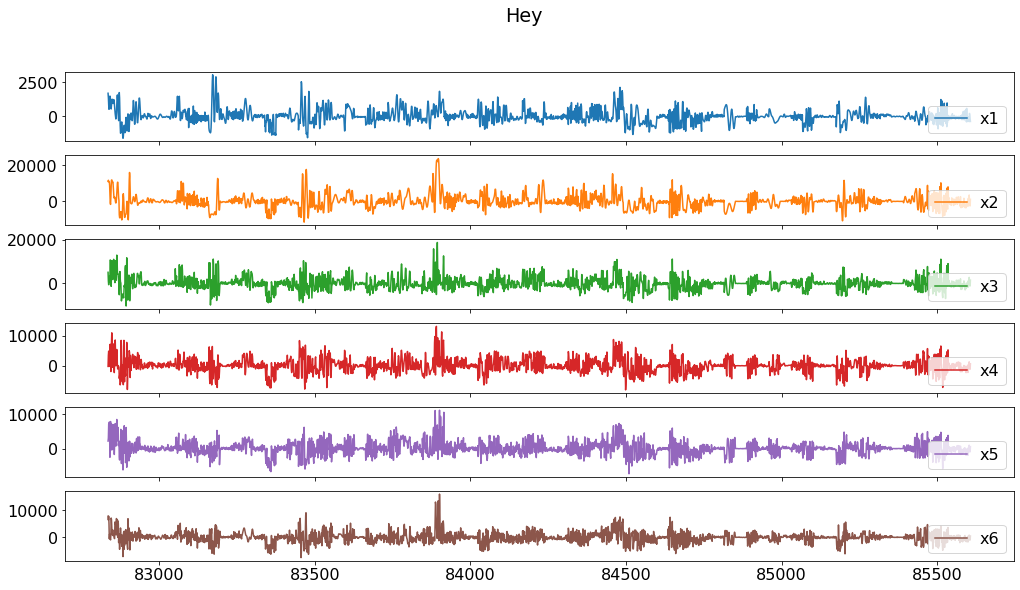

In [19]:
inspect_category("Hey", df)

### Correlation analysis between features

In [21]:
from scipy.stats import pearsonr

def corrfunc(df,cate):
  """Plot the correlation coefficient in the top left hand corner of a plot."""
  id_cate=np.array(df[df['category']==cate]['id'].unique())
  r =n p.zeros((6,6))
  for id in id_cate:
    temp_df = df[df['id']==id]
    r = np.add( r,temp_df[['x1','x2','x3','x4','x5','x6']].corr(method = 'pearson'))
  return r/id_cate.size

def totalcorr(df):
  r = np.zeros((6,6))
  categories = df['category'].unique()

  for cate in categories:
    r = np.add( r,corrfunc(df,cate))

  return r/categories.size

totalcorr(ds_df) # com:   seems that we can take out x4 because it is highly correlated to the other features

,x1,x2,x3,x4,x5,x6
x1,1.000000,0.176958,0.176448,0.167567,0.117991,0.098395
x2,0.176958,1.000000,0.484000,0.454846,0.363699,0.307924
x3,0.176448,0.484000,1.000000,0.535408,0.445944,0.370291
x4,0.167567,0.454846,0.535408,1.000000,0.482469,0.405208
x5,0.117991,0.363699,0.445944,0.482469,1.000000,0.458329
x6,0.098395,0.307924,0.370291,0.405208,0.458329,1.000000


## Prepare dataset for training

### Split

The number of windows per category is equal the number of elements divided with the size of the original window.

In [22]:
df = ds_df
entries_per_category = df.groupby('category').count()['user_id'] / 36
entries_per_category

category
0      34.0
1     123.0
2     270.0
3     381.0
4      62.0
5     153.0
6     313.0
7      68.0
8     120.0
9     777.0
10     77.0
11     51.0
Name: user_id, dtype: float64

A simple loop over all the elements for the split. The original windows are maintained by considering the `id` field.

In [23]:
ds_train_df = pd.DataFrame()
ds_val_df = pd.DataFrame()

val_split = 0.2

val = np.zeros(12)

for id in ds_df['id'].unique():
  df = ds_df
  values = df[df['id'] == id]
  category = values['category'].values[0]

  # check if 
  if val[category] < val_split * entries_per_category[category]:
    ds_val_df = pd.concat([ds_val_df, values])
    val[category] += 1
  else:
    ds_train_df = pd.concat([ds_train_df, values])

ds_train_df.shape, ds_val_df.shape

((69768, 9), (17676, 9))

### Build sequences

Create only windows with a size of 36.

We do not know anything about the correlation between the original windows. Maybe they are not consecutive and also they could be randomly ordered. At least, data should be time relative inside the same window.

For these reasons we did not try with stride or different window size. Also, Codalab wants input shape of (36, 6).

In [24]:
window = 36

In [25]:
def build_sequences(df, window=36):
    # Sanity check to avoid runtime errors
    dataset = []
    labels = []

    # Read data by unique id
    # In this case an id represents a single original window
    for id in df['id'].unique():
        temp = df[df['id'] == id][['x1','x2','x3','x4','x5','x6']].values
        label = df[df['id'] == id]['category'].values[0]

        # Check if padding is needed
        if len(temp) % window != 0:
          # Compute padding length
          padding_len = window - len(temp)%window
          # Create padding and concatenate it
          padding = np.zeros((padding_len, 6), dtype='float64')
          temp = np.concatenate((temp,padding))

        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            dataset.append(temp[idx:idx+window])
            labels.append(label)
            idx += window # here should be a stride value, but we always considered stride = window

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

Build sequences for training and validation.

In [26]:
x_train_raw, y_train_raw = build_sequences(ds_train_df, window)
x_val_raw, y_val_raw = build_sequences(ds_val_df, window)
x_train_raw.shape, y_train_raw.shape, x_val_raw.shape, y_val_raw.shape

((1938, 36, 6), (1938,), (491, 36, 6), (491,))

### Save original dataset splitted

The splitted dataset is save in training and validation-

In [27]:
x_train, y_train = x_train_raw, y_train_raw
x_val, y_val = x_val_raw, y_val_raw

### Oversampling

The target means how many windows should each category have at the end of the oversampling process.

In [28]:
oversampling_target = 800

In [29]:
print("Before oversampling")
print(x_train_raw.shape, y_train_raw.shape)

Before oversampling
(1938, 36, 6) (1938,)


Count entries per category for later use

In [30]:
categories_count = np.zeros(12)
for i in range(len(x_train_raw)):
  y = y_train_raw[i]
  categories_count[y] += 1
categories_count

array([ 27.,  98., 216., 304.,  49., 122., 250.,  54.,  96., 621.,  61.,
        40.])

A simple loop over all the windows. Each window could be copied multiple times if needed to reach the target.

In [31]:
x_train_ov = x_train_raw
y_train_ov = y_train_raw

# Calculate number of copies to make for each category based on the initial amount
category_copies = np.zeros(12)
for i in range(12):
  category_copies[i] = oversampling_target // categories_count[i] + 1

# Create copies
for i in range(len(x_train_raw)):
  x = x_train_raw[i]
  y = y_train_raw[i]

  # Items from categories with few samples will be copied more than one time
  j = 0
  while(categories_count[y] < oversampling_target and j < category_copies[y]):
    x_train_ov = np.append(x_train_ov, [x], axis=0)
    y_train_ov = np.append(y_train_ov, y)
    categories_count[y] += 1
    j += 1

categories_count

array([800., 800., 800., 800., 800., 800., 800., 800., 800., 800., 800.,
       800.])

x_train_ov.shape, x_train_ov.shape

### Convert labels

In [32]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train, num_classes=12)
y_train_ov = tfk.utils.to_categorical(y_train_ov, num_classes=12)
y_val = tfk.utils.to_categorical(y_val, num_classes=12)

y_train.shape, y_val.shape

((1938, 12), (491, 12))

### Results

In [33]:
print("Original\t", x_train_orig.shape, y_train_orig.shape)
print("Training\t", x_train.shape, y_train.shape)
print("Validation\t", x_val.shape, y_val.shape)
print("Oversampling\t", x_train_ov.shape, x_train_ov.shape)

Original	 (2429, 36, 6) (2429, 12)
Training	 (1938, 36, 6) (1938, 12)
Validation	 (491, 36, 6) (491, 12)
Oversampling	 (9600, 36, 6) (9600, 36, 6)


### Save new data

In [34]:
!rm -rf dataset.zip

In [35]:
np.save("x_train.npy", x_train)
np.save("y_train.npy", y_train)
np.save("x_train_ov.npy", x_train_ov)
np.save("y_train_ov.npy", y_train_ov)
np.save("x_val.npy", x_val)
np.save("y_val.npy", y_val)

In [36]:
os.system("zip -r dataset.zip x_train.npy")
os.system("zip -r dataset.zip y_train.npy")
os.system("zip -r dataset.zip x_train_ov.npy")
os.system("zip -r dataset.zip y_train_ov.npy")
os.system("zip -r dataset.zip x_val.npy")
os.system("zip -r dataset.zip y_val.npy")

0